<a href="https://colab.research.google.com/github/delemarchand2020/DeepLearning/blob/main/Projet_G%C3%A9n%C3%A9ration_de_sc%C3%A9narios_et_renforcement_Denis_Lemarchand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation des librairies

In [ ]:
!pip install chess

In [ ]:
!pip install stockfish

In [ ]:
!wget https://www.dropbox.com/sh/75gzfgu7qo94pvh/AACk_w5M94GTwwhSItCqsemoa/Stockfish%205/stockfish-5-linux.zip
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gnoo7zvmhn35gUy093Eltw6a-PWOIpwz' -O stockfish-5-linux.zip

In [ ]:
!unzip stockfish-5-linux.zip

In [ ]:
!chmod +x stockfish-5-linux/Linux/stockfish_14053109_x64

In [ ]:
!ls -l stockfish-5-linux/Linux/stockfish_14053109_x64

##Tests python-chess

<bound method Board.status of Board('2K5/6R1/6Qk/3N4/8/5p2/8/8 b - - 3 69')> 137 1-0


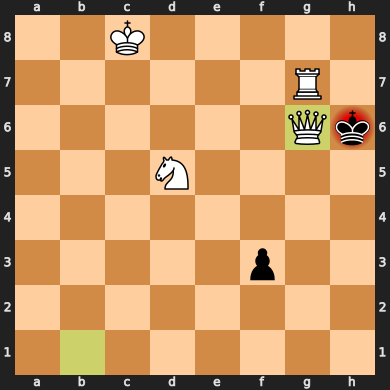

In [766]:
import chess
import chess.engine

engine = chess.engine.SimpleEngine.popen_uci(r"./stockfish-5-linux/Linux/stockfish_14053109_x64")

max_iter = 1000
k = 0

board = chess.Board()
while not board.is_game_over() and k < max_iter:
    if(board.turn): #blanc
      white_player = engine.play(board, chess.engine.Limit(time=0.01))#, depth=2, nodes=5))
      board.push(white_player.move)
    else:
      black_player = engine.play(board, chess.engine.Limit(time=0.001))
      board.push(black_player.move)
    k += 1

engine.quit()

print(board.status, k, board.result())
board

##Fonctions utilitaires (issues de RLC)

In [ ]:
def get_project_legal_moves(board):
        """
        Create a mask of legal actions
        Returns: np.ndarray with shape (64,64)
        """
        action_space = np.zeros(shape=(64, 64))
        moves = [[x.from_square, x.to_square] for x in board.generate_legal_moves()]
        for move in moves:
            action_space[move[0], move[1]] = 1
        return action_space

In [ ]:
def get_layer_board(board):
        """
        Initalize the numerical representation of the environment
        Returns:
        """
        layer_board = np.zeros(shape=(8, 8, 8))
        for i in range(64):
            row = i // 8
            col = i % 8
            piece = board.piece_at(i)
            if piece == None:
                continue
            elif piece.symbol().isupper():
                sign = 1
            else:
                sign = -1
            layer = mapper[piece.symbol()]
            layer_board[layer, row, col] = sign
        if board.turn:
            layer_board[6, :, :] = 1 / board.fullmove_number
        if board.can_claim_draw():
            layer_board[7, :, :] = 1
        return layer_board

In [ ]:
def next_white_move(agent, board, debug=False, best_probs=False):        
  states = []
  actions = []
  rewards = []
  action_spaces = []

  state = get_layer_board(board)
  action_space = get_project_legal_moves(board) # The environment determines which moves are legal
  action_probs = agent.model.predict([np.expand_dims(state, axis=0),
                                       np.zeros((1, 1)),
                                       action_space.reshape(1, 4096)])
  action_probs = action_probs / action_probs.sum()
  move = np.random.choice(range(4096), p=np.squeeze(action_probs))
  if(debug):
    print(move, np.argmax(action_probs, axis=1)[0])
  if(best_probs):
    move = np.argmax(action_probs, axis=1)[0]
  move_from = move // 64
  move_to = move % 64
  moves = [x for x in board.generate_legal_moves() if \
           x.from_square == move_from and x.to_square == move_to]
  assert len(moves) > 0  # should not be possible
  if len(moves) > 1:
    move = np.random.choice(moves)  # If there are multiple max-moves, pick a random one.
  elif len(moves) == 1:
    move = moves[0]
  return move      

In [ ]:
def get_random_action(board):
  legal_moves = [x for x in board.generate_legal_moves()]
  legal_moves = np.random.choice(legal_moves)
  return legal_moves

#Génération des configurations de l’échiquier avec un $β$-VAE

##Librairies

In [901]:
import torch
use_gpu = False
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

# Imports des bibliothèques utiles
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

Exécution sur cpu


##Hyperparamètres

Wout = (Win - K + 2P)/S + 1

Hout = (Hin - K + 2P)/S + 1

K:Kernel

P:Padding

S:Stride

In [902]:
Kernel_size = 3
Stride_size = 1
Padding_size = 1
N_channels_1 = 11
N_channels_2 = 11

seuil_proba_prediction = 0.5

W_in = 8
H_in = 8

W_out = (W_in - Kernel_size + 2*Padding_size)/Stride_size + 1
H_out = (H_in - Kernel_size + 2*Padding_size)/Stride_size + 1

print(W_out,H_out)

W_out = int(W_out)
H_out = int(H_out)

8.0 8.0


In [903]:
beta = 0.3
latent_dimension = 100
batch_size = 32

N_epochs = 20
learning_rate = 0.001

In [904]:
Taille_DA = 20000
Taille_DT = 4000

##Conversion échiquier <-> numpy board

In [905]:
def board_to_numpy(board):
        """
        Initalize the numerical representation of the environment
        Returns:
        """
        layer_board = np.zeros(shape=(6, 8, 8))
        for i in range(64):
            row = i // 8
            col = i % 8
            piece = board.piece_at(i)
            if piece == None:
                continue
            elif piece.symbol().isupper():
                sign = 1
            else:
                sign = -1
            layer = mapper[piece.symbol()]
            layer_board[layer, row, col] = sign
        return layer_board


In [906]:
mapper = {}
#pieces noires
mapper["p"] = 0 #pion 
mapper["r"] = 1 #tour
mapper["n"] = 2 #cavalier
mapper["b"] = 3 #fou
mapper["q"] = 4 #reine
mapper["k"] = 5 #roi
#pieces blanches
mapper["P"] = 0
mapper["R"] = 1
mapper["N"] = 2
mapper["B"] = 3
mapper["Q"] = 4
mapper["K"] = 5

layer = {}
layer[0] = chess.PAWN
layer[1] = chess.ROOK
layer[2] = chess.KNIGHT
layer[3] = chess.BISHOP
layer[4] = chess.QUEEN
layer[5] = chess.KING

def numpy_to_board(layer_board):
    board = chess.Board.empty()
    for l in range(6):
       for row in range(8):
          for col in range(8):
             piece = layer_board[l][row][col]
             if piece == 1: #blanche
               c = chess.WHITE
             elif piece == -1: #noire
               c = chess.BLACK
             else:
               continue
             p = chess.Piece(layer[l],c)
             board.set_piece_at(row*8+col, piece=p)
    return board      

##Préparation du dataset des configurations

In [907]:
# Configurer une instance de stockfish, une zone mémoire D pour stocker les configurations réelles d’échiquiers.
import chess
import chess.engine

class DatasetConfigBoard(object):

    def __init__(self, N=1000, N_test=200):
        self.N = N
        self.memory_DA = torch.Tensor(size=(N,6,8,8))
        self.memory_DT = torch.Tensor(size=(N_test,6,8,8))
        self.memory_Boards = [] #pour tests
        self.N_test = N_test

        self.stat_nb_parties = 0
        self.stat_nb_moyen_coups_par_parties = 0
        self.nb_victoires_blancs = 0
        self.nb_victoires_noirs = 0
        self.nb_fois_atteinte_max_iter = 0

        #self.nb_moyen_captures_blancs_par_parties = 0
        #self.nb_moyen_captures_noirs_par_parties = 0

    def generate(self, N, memory_D, memory_Boards, calculs_stats = False):
        engine = chess.engine.SimpleEngine.popen_uci(r"./stockfish-5-linux/Linux/stockfish_14053109_x64")
        i = 0
        while i < N:
          max_iter = 1000
          k = 0
          board = chess.Board()
          while not board.is_game_over() and k < max_iter and i < N:
              if(board.turn): #blanc
                white_player = engine.play(board, chess.engine.Limit(time=0.01))
                board.push(white_player.move)
              else:
                black_player = engine.play(board, chess.engine.Limit(time=0.01))
                board.push(black_player.move)
              k += 1
              memory_D[i] = torch.Tensor(board_to_numpy(board))
              memory_Boards.append(board.copy())
              i += 1
          
          if calculs_stats:
              self.stat_nb_parties += 1
              self.stat_nb_moyen_coups_par_parties += k
                        
              if k == max_iter:
                self.nb_fois_atteinte_max_iter += 1
          
              if board.result() == "1-0":
                self.nb_victoires_blancs += 1

              if board.result() == "0-1":
                self.nb_victoires_noirs += 1

        if calculs_stats:
            self.stat_nb_moyen_coups_par_parties = self.stat_nb_moyen_coups_par_parties/self.stat_nb_parties
        engine.quit()

    def create_dataset(self):
        self.generate(self.N, self.memory_DA, self.memory_Boards, calculs_stats = True)
        self.generate(self.N_test, self.memory_DT, self.memory_Boards)
        return self.memory_DA, self.memory_DT

    def get_stats(self):
        print(f"nb_parties {self.stat_nb_parties}")
        print(f"nb_moyen_coups_par_parties {self.stat_nb_moyen_coups_par_parties}")
        print(f"nb_victoires_blancs {self.nb_victoires_blancs}")
        print(f"nb_victoires_noirs {self.nb_victoires_noirs}")
        print(f"nb_matchs_nuls {self.stat_nb_parties - self.nb_victoires_noirs - self.nb_victoires_blancs}")
        print(f"nb_fois_atteinte_max_iter {self.nb_fois_atteinte_max_iter}")

In [908]:
dataset_config = DatasetConfigBoard(N=Taille_DA, N_test=Taille_DT)
DA, DT = dataset_config.create_dataset()

In [909]:
# normalisation : -1 -> 0, 0 -> 0.5, 1 -> 1
# normalisation(x): (x + 1)/2
def normalisation(x):
  return (x+1)/2

def de_normalisation(x):
  return (2*x - 1)

In [910]:
DA_copy = DA
DT_copy = DT

In [911]:
DA = normalisation(DA_copy)
DT = normalisation(DT_copy)

In [912]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(DA, batch_size=batch_size, shuffle=True)

##Implémentation $\beta$-VAE

In [913]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(6, N_channels_1, kernel_size=Kernel_size, stride=Stride_size, padding=Padding_size),
                                     nn.ReLU(),
                                     nn.Conv2d(N_channels_1, N_channels_2, kernel_size=Kernel_size, stride=Stride_size, padding=Padding_size),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                   )
        self.linear1 = nn.Linear(in_features=(N_channels_2*W_out*H_out), out_features=latent_dimension)
        self.linear2 = nn.Linear(in_features=(N_channels_2*W_out*H_out), out_features=latent_dimension)

    def forward(self, x):
        x = self.model(x)
        x_mu = self.linear1(x)
        x_logvar = self.linear2(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(in_features=latent_dimension, out_features=N_channels_2*W_out*H_out)
        self.model = nn.Sequential(nn.ConvTranspose2d(N_channels_2, N_channels_1, kernel_size=Kernel_size, stride=Stride_size, padding=Padding_size),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(N_channels_1, 6, kernel_size=Kernel_size, stride=Stride_size, padding=Padding_size),
                                     nn.Sigmoid()
                                    )

    def forward(self, z):
        hat_x = F.relu(self.linear(z))
        hat_x = hat_x.view(-1, N_channels_2, W_out, H_out)
        hat_x = self.model(hat_x)
        return hat_x

In [914]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        z = self.latent_sample(latent_mu, latent_logvar)
        hat_x = self.decoder(z)
        return hat_x, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [915]:
def vae_loss(hat_x, x, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 6*8*8), x.view(-1, 6*8*8), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + beta * kl_divergence

##Apprentissage $\beta$-VAE

In [916]:
from tqdm.notebook import trange, tqdm

def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Choix de la fonction de coût
    criterion = vae_loss
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images in tqdm(train_dataloader):
            # les labels sont ignorés pour l'apprentissage de l'auto-encodeur

            images = images.to(device)
            # Calcul de la reconstruction
            reconstructions, latent_mu, latent_logvar = net(images)
            # Calcul de l'erreur
            loss = criterion(reconstructions, images, latent_mu, latent_logvar)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu")

In [917]:
vae = VariationalAutoencoder(latent_dimension)
train_vae(vae, DA, epochs=N_epochs, learning_rate=learning_rate, batch_size=batch_size)

Entraînement du modèle:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

VariationalAutoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(6, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(11, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (linear1): Linear(in_features=704, out_features=100, bias=True)
    (linear2): Linear(in_features=704, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=100, out_features=704, bias=True)
    (model): Sequential(
      (0): ConvTranspose2d(11, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(11, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Sigmoid()
    )
  )
)

##Tests de génération de configurations synthétiques

###Cas a : la reconstruction est-elle identique à l’entrée, est-elle valide ?

In [918]:
def predict_layer_board(fake_config_board, p=0.5):
  layer_board = torch.round(fake_config_board, decimals=2)
  layer_board[layer_board>p] = 1
  layer_board[layer_board<-p] = -1
  layer_board[torch.abs(layer_board)!=1] = 0
  return layer_board

In [919]:
vae.eval()
reconstruction,_,_ = vae(DT)

In [920]:
reconstruction_config_board = de_normalisation(reconstruction.detach())
reconstruction_layer_board = predict_layer_board(reconstruction_config_board, p=seuil_proba_prediction)

Status.VALID


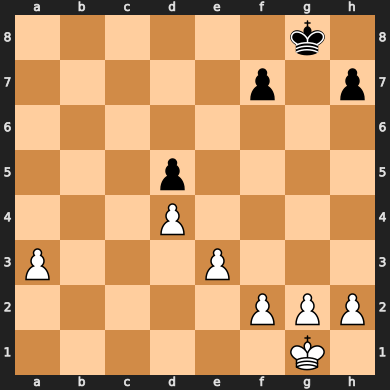

In [921]:
n = 354
b = numpy_to_board(reconstruction_layer_board[n].numpy())
print(b.status())
b

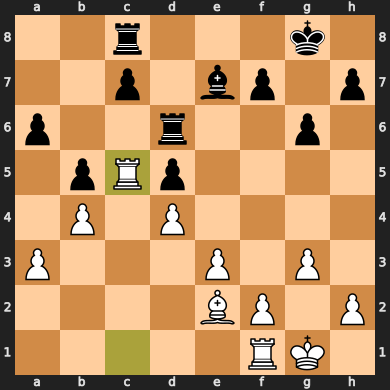

In [922]:
dataset_config.memory_Boards[len(DA)+n]

In [923]:
print(b.board_fen())
print(dataset_config.memory_Boards[len(DA)+n].board_fen())

6k1/5p1p/8/3p4/3P4/P3P3/5PPP/6K1
2r3k1/2p1bp1p/p2r2p1/1pRp4/1P1P4/P3P1P1/4BP1P/5RK1


In [924]:
cas_a_invalide = 0
cas_a_invalide_DT = 0
cas_a_different = 0

invalide_board_DT = []

for i in range(len(reconstruction_layer_board)):
  b = numpy_to_board(reconstruction_layer_board[i].numpy())
  b_DT = numpy_to_board(de_normalisation(DT)[i].numpy())
  cas_a_invalide += int(b.status() != chess.STATUS_VALID)
  if b_DT.status() != chess.STATUS_VALID:
    cas_a_invalide_DT += 1
    invalide_board_DT.append(b_DT)
  cas_a_different += int(b.board_fen() != dataset_config.memory_Boards[len(DA)+i].board_fen())

Status.OPPOSITE_CHECK


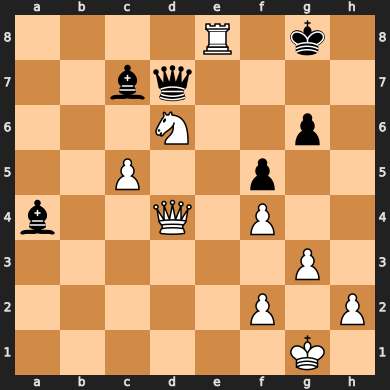

In [925]:
print(invalide_board_DT[30].status())
invalide_board_DT[30]

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R


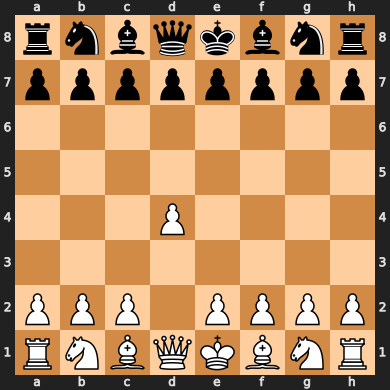

In [926]:
print(de_normalisation(DT)[0][0])
b_DT = numpy_to_board(de_normalisation(DT)[0].numpy())
print(b_DT)
int(dataset_config.memory_Boards[len(DA)+0].status() != chess.STATUS_VALID)
b_DT

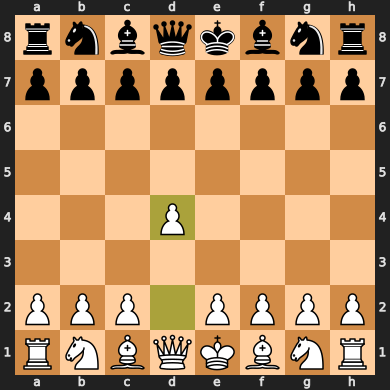

In [927]:
dataset_config.memory_Boards[len(DA)+0]

###Cas b : est-ce une configuration synthétique valide ?

In [928]:
vae.eval()

with torch.no_grad():

    # Échantillonnage selon une loi normale
    latent = torch.randn(Taille_DT, latent_dimension, device=device)

    # Reconstruction
    fake_config_board = de_normalisation(vae.decoder(latent).cpu())

In [929]:
pred_layer_board = predict_layer_board(fake_config_board, p=seuil_proba_prediction)
#pred_layer_board[4]

Status.TOO_MANY_WHITE_PAWNS


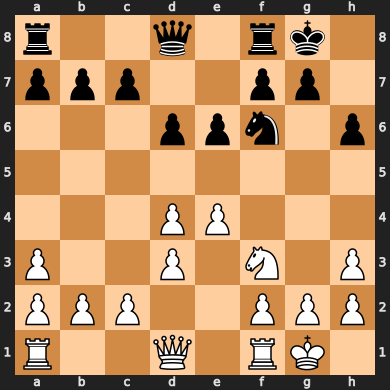

In [930]:
b = numpy_to_board(pred_layer_board[5].numpy())
print(b.status())
b

In [931]:
cas_b_invalide = 0
for i in range(len(pred_layer_board)):
  b = numpy_to_board(pred_layer_board[i].numpy())
  cas_b_invalide += (b.status() != chess.STATUS_VALID)

#Résultats générations configurations

In [932]:
dataset_config.get_stats() #sur dataset apprentissage

nb_parties 120
nb_moyen_coups_par_parties 166.66666666666666
nb_victoires_blancs 31
nb_victoires_noirs 32
nb_matchs_nuls 57
nb_fois_atteinte_max_iter 0


In [933]:
print(f"cas a : taux d'échec (validité) de {cas_a_invalide*100/len(reconstruction_layer_board)}%")
print(f"cas a : taux de différence {cas_a_different*100/len(reconstruction_layer_board)}%")
print(f"cas a : [DT]taux d'échec (validité) de {cas_a_invalide_DT*100/len(reconstruction_layer_board)}%")

cas a : taux d'échec (validité) de 70.125%
cas a : taux de différence 100.0%
cas a : [DT]taux d'échec (validité) de 4.875%


In [934]:
print(f"cas b : taux d'échec de {cas_b_invalide*100/len(pred_layer_board)}%")

cas b : taux d'échec de 73.45%


#Tests RLC "capture"

##RLC "capture"
[Reprise du code de la librairie RLC de arjangroen](https://github.com/arjangroen/RLC/tree/master/RLC/capture_chess)

In [ ]:
#@title Agent
import tensorflow as tf
import keras

from keras.models import Model, clone_model
from keras.layers import Input, Conv2D, Dense, Reshape, Dot, Activation, Multiply
from tensorflow.keras.optimizers import SGD

import numpy as np
import keras.backend as K


def policy_gradient_loss(Returns):
    def modified_crossentropy(action, action_probs):
        cost = (K.categorical_crossentropy(action, action_probs, from_logits=False, axis=1) * Returns)
        return K.mean(cost)

    return modified_crossentropy


class Agent(object):

    def __init__(self, gamma=0.5, network='linear', lr=0.01, verbose=0):
        """
        Agent that plays the white pieces in capture chess
        Args:
            gamma: float
                Temporal discount factor
            network: str
                'linear' or 'conv'
            lr: float
                Learning rate, ideally around 0.1
        """
        self.gamma = gamma
        self.network = network
        self.lr = lr
        self.verbose = verbose
        self.init_network()
        self.weight_memory = []
        self.long_term_mean = []

    def init_network(self):
        """
        Initialize the network
        Returns:

        """
        if self.network == 'linear':
            self.init_linear_network()
        elif self.network == 'conv':
            self.init_conv_network()
        elif self.network == 'conv_pg':
            self.init_conv_pg()

    def fix_model(self):
        """
        The fixed model is the model used for bootstrapping
        Returns:
        """
        optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        self.fixed_model = clone_model(self.model)
        self.fixed_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        self.fixed_model.set_weights(self.model.get_weights())

    def init_linear_network(self):
        """
        Initialize a linear neural network
        Returns:

        """
        optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        input_layer = Input(shape=(8, 8, 8), name='board_layer')
        reshape_input = Reshape((512,))(input_layer)
        output_layer = Dense(4096)(reshape_input)
        self.model = Model(inputs=[input_layer], outputs=[output_layer])
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def init_conv_network(self):
        """
        Initialize a convolutional neural network
        Returns:

        """
        optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        input_layer = Input(shape=(8, 8, 8), name='board_layer')
        inter_layer_1 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        inter_layer_2 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        flat_1 = Reshape(target_shape=(1, 64))(inter_layer_1)
        flat_2 = Reshape(target_shape=(1, 64))(inter_layer_2)
        output_dot_layer = Dot(axes=1)([flat_1, flat_2])
        output_layer = Reshape(target_shape=(4096,))(output_dot_layer)
        self.model = Model(inputs=[input_layer], outputs=[output_layer])
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def init_conv_pg(self):
        """
        Convnet net for policy gradients
        Returns:

        """
        optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        input_layer = Input(shape=(8, 8, 8), name='board_layer')
        R = Input(shape=(1,), name='Rewards')
        legal_moves = Input(shape=(4096,), name='legal_move_mask')
        inter_layer_1 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        inter_layer_2 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        flat_1 = Reshape(target_shape=(1, 64))(inter_layer_1)
        flat_2 = Reshape(target_shape=(1, 64))(inter_layer_2)
        output_dot_layer = Dot(axes=1)([flat_1, flat_2])
        output_layer = Reshape(target_shape=(4096,))(output_dot_layer)
        softmax_layer = Activation('softmax')(output_layer)
        legal_softmax_layer = Multiply()([legal_moves, softmax_layer])  # Select legal moves
        self.model = Model(inputs=[input_layer, R, legal_moves], outputs=[legal_softmax_layer])
        self.model.compile(optimizer=optimizer, loss=policy_gradient_loss(R))

    def network_update(self, minibatch):
        """
        Update the Q-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """

        # Prepare separate lists
        states, moves, rewards, new_states = [], [], [], []
        td_errors = []
        episode_ends = []
        for sample in minibatch:
            states.append(sample[0])
            moves.append(sample[1])
            rewards.append(sample[2])
            new_states.append(sample[3])

            # Episode end detection
            if np.array_equal(sample[3], sample[3] * 0):
                episode_ends.append(0)
            else:
                episode_ends.append(1)

        # The Q target
        q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(
            self.fixed_model.predict(np.stack(new_states, axis=0)), axis=1)

        # The Q value for the remaining actions
        q_state = self.model.predict(np.stack(states, axis=0))  # batch x 64 x 64

        # Combine the Q target with the other Q values.
        q_state = np.reshape(q_state, (len(minibatch), 64, 64))
        for idx, move in enumerate(moves):
            td_errors.append(q_state[idx, move[0], move[1]] - q_target[idx])
            q_state[idx, move[0], move[1]] = q_target[idx]
        q_state = np.reshape(q_state, (len(minibatch), 4096))

        # Perform a step of minibatch Gradient Descent.
        self.model.fit(x=np.stack(states, axis=0), y=q_state, epochs=1, verbose=0)

        return td_errors

    def get_action_values(self, state):
        """
        Get action values of a state
        Args:
            state: np.ndarray with shape (8,8,8)
                layer_board representation

        Returns:
            action values

        """
        return self.fixed_model.predict(state) + np.random.randn() * 1e-9

    def policy_gradient_update(self, states, actions, rewards, action_spaces, actor_critic=False):
        """
        Update parameters with Monte Carlo Policy Gradient algorithm
        Args:
            states: (list of tuples) state sequence in episode
            actions: action sequence in episode
            rewards: rewards sequence in episode

        Returns:

        """
        n_steps = len(states)
        Returns = []
        targets = np.zeros((n_steps, 64, 64))
        for t in range(n_steps):
            action = actions[t]
            targets[t, action[0], action[1]] = 1
            if actor_critic:
                R = rewards[t, action[0] * 64 + action[1]]
            else:
                R = np.sum([r * self.gamma ** i for i, r in enumerate(rewards[t:])])
            Returns.append(R)

        if not actor_critic:
            mean_return = np.mean(Returns)
            self.long_term_mean.append(mean_return)
            train_returns = np.stack(Returns, axis=0) - np.mean(self.long_term_mean)
        else:
            train_returns = np.stack(Returns, axis=0)
        # print(train_returns.shape)
        targets = targets.reshape((n_steps, 4096))
        self.weight_memory.append(self.model.get_weights())
        self.model.fit(x=[np.stack(states, axis=0),
                          train_returns,
                          np.concatenate(action_spaces, axis=0)
                          ],
                       y=[np.stack(targets, axis=0)],
                       verbose=self.verbose
                       )

In [ ]:
#@title Environnement
import chess
import chess.engine
import numpy as np

mapper = {}
mapper["p"] = 0
mapper["r"] = 1
mapper["n"] = 2
mapper["b"] = 3
mapper["q"] = 4
mapper["k"] = 5
mapper["P"] = 0
mapper["R"] = 1
mapper["N"] = 2
mapper["B"] = 3
mapper["Q"] = 4
mapper["K"] = 5


class Board(object):

    def __init__(self, FEN=None):
        """
        Chess Board Environment
        Args:
            FEN: str
                Starting FEN notation, if None then start in the default chess position
        """
        self.FEN = FEN
        self.board = chess.Board(self.FEN) if self.FEN else chess.Board()
        self.init_action_space()
        self.layer_board = np.zeros(shape=(8, 8, 8))
        self.init_layer_board()

    def init_action_space(self):
        """
        Initialize the action space
        Returns:
        """
        self.action_space = np.zeros(shape=(64, 64))

    def init_layer_board(self):
        """
        Initalize the numerical representation of the environment
        Returns:
        """
        self.layer_board = np.zeros(shape=(8, 8, 8))
        for i in range(64):
            row = i // 8
            col = i % 8
            piece = self.board.piece_at(i)
            if piece == None:
                continue
            elif piece.symbol().isupper():
                sign = 1
            else:
                sign = -1
            layer = mapper[piece.symbol()]
            self.layer_board[layer, row, col] = sign
        if self.board.turn:
            self.layer_board[6, :, :] = 1 / self.board.fullmove_number
        if self.board.can_claim_draw():
            self.layer_board[7, :, :] = 1

    def step(self, action, opponent=None):
        """
        Run a step
        Args:
            action: tuple of 2 integers
                Move from, Move to
        Returns:
            epsiode end: Boolean
                Whether the episode has ended
            reward: int
                Difference in material value after the move
        """
        piece_balance_before = self.get_material_value()
        self.board.push(action)
        self.init_layer_board()
        piece_balance_after = self.get_material_value()
        if self.board.result() == "*":
            if opponent == None:
              opponent_move = self.get_random_action()
            else:
              PlayResult = opponent.play(self.board, chess.engine.Limit(time=0.1, depth=4, nodes=4))
              opponent_move = PlayResult.move
            self.board.push(opponent_move)
            self.init_layer_board() 
            capture_reward = piece_balance_after - piece_balance_before
            if self.board.result() == "*":
                reward = 0 + capture_reward
                episode_end = False
            else:
                if self.board.result() == "1-0":
                  reward = 40 + capture_reward
                else:
                  reward = 0 + capture_reward
                episode_end = True
        else:
            capture_reward = piece_balance_after - piece_balance_before
            if self.board.result() == "1-0":
                  reward = 40 + capture_reward
            else:
                  reward = 0 + capture_reward
            episode_end = True
        if self.board.is_game_over():
            reward = 0
            episode_end = True
        return episode_end, reward

    def get_random_action(self):
        """
        Sample a random action
        Returns: move
            A legal python chess move.
        """
        legal_moves = [x for x in self.board.generate_legal_moves()]
        legal_moves = np.random.choice(legal_moves)
        return legal_moves

    def project_legal_moves(self):
        """
        Create a mask of legal actions
        Returns: np.ndarray with shape (64,64)
        """
        self.action_space = np.zeros(shape=(64, 64))
        moves = [[x.from_square, x.to_square] for x in self.board.generate_legal_moves()]
        for move in moves:
            self.action_space[move[0], move[1]] = 1
        return self.action_space

    def get_material_value(self):
        """
        Sums up the material balance using Reinfield values
        Returns: The material balance on the board
        """
        pawns = 1 * np.sum(self.layer_board[0, :, :])
        rooks = 5 * np.sum(self.layer_board[1, :, :])
        minor = 3 * np.sum(self.layer_board[2:4, :, :])
        queen = 9 * np.sum(self.layer_board[4, :, :])
        return pawns + rooks + minor + queen

    def reset(self):
        """
        Reset the environment
        Returns:
        """
        self.board = chess.Board(self.FEN) if self.FEN else chess.Board()
        self.init_layer_board()
        self.init_action_space()

In [ ]:
#@title Learn
import numpy as np
from chess.pgn import Game
import pandas as pd


class Q_learning(object):

    def __init__(self, agent, env, memsize=1000):
        """
        Reinforce object to learn capture chess
        Args:
            agent: The agent playing the chess game as white
            env: The environment including the python-chess board
            memsize: maximum amount of games to retain in-memory
        """
        self.agent = agent
        self.env = env
        self.memory = []
        self.memsize = memsize
        self.reward_trace = []
        self.memory = []
        self.sampling_probs = []

    def learn(self, iters=100, c=10, windows_r_average=10):
        """
        Run the Q-learning algorithm. Play greedy on the final iter
        Args:
            iters: int
                amount of games to train
            c: int
                update the network every c games

        Returns: pgn (str)
            pgn string describing final game

        """
        for k in range(iters):
            greedy = True if k == iters - 1 else False
            self.env.reset()
            self.play_game(k, greedy=greedy)
            if k % c == 0:
                all_r = np.array(self.reward_trace)
                r_average = all_r[-windows_r_average:].mean()
                print("iter", k, " r_average", r_average)
                self.agent.fix_model()

        pgn = Game.from_board(self.env.board)
        reward_smooth = pd.DataFrame(self.reward_trace)
        reward_smooth.rolling(window=10, min_periods=0).mean().plot()

        return pgn

    def play_game(self, k, greedy=False, maxiter=25):
        """
        Play a game of capture chess
        Args:
            k: int
                game count, determines epsilon (exploration rate)
            greedy: Boolean
                if greedy, no exploration is done
            maxiter: int
                Maximum amount of steps per game

        Returns:

        """
        episode_end = False
        turncount = 0

        # Here we determine the exploration rate. k is divided by 250 to slow down the exploration rate decay.
        eps = max(0.05, 1 / (1 + (k / 250))) if not greedy else 0.

        # Play a game of chess
        while not episode_end:
            state = self.env.layer_board
            explore = np.random.uniform(0, 1) < eps  # determine whether to explore
            if explore:
                move = self.env.get_random_action()
                move_from = move.from_square
                move_to = move.to_square
            else:
                action_values = self.agent.get_action_values(np.expand_dims(state, axis=0))
                action_values = np.reshape(np.squeeze(action_values), (64, 64))
                action_space = self.env.project_legal_moves()  # The environment determines which moves are legal
                action_values = np.multiply(action_values, action_space)
                move_from = np.argmax(action_values, axis=None) // 64
                move_to = np.argmax(action_values, axis=None) % 64
                moves = [x for x in self.env.board.generate_legal_moves() if \
                         x.from_square == move_from and x.to_square == move_to]
                if len(moves) == 0:  # If all legal moves have negative action value, explore.
                    move = self.env.get_random_action()
                    move_from = move.from_square
                    move_to = move.to_square
                else:
                    move = np.random.choice(moves)  # If there are multiple max-moves, pick a random one.

            episode_end, reward = self.env.step(move)
            new_state = self.env.layer_board
            if len(self.memory) > self.memsize:
                self.memory.pop(0)
                self.sampling_probs.pop(0)
            turncount += 1
            if turncount > maxiter:
                episode_end = True
                reward = 0
            if episode_end:
                new_state = new_state * 0
            self.memory.append([state, (move_from, move_to), reward, new_state])
            self.sampling_probs.append(1)

            self.reward_trace.append(reward)

            self.update_agent(turncount)

        return self.env.board

    def sample_memory(self, turncount):
        """
        Get a sample from memory for experience replay
        Args:
            turncount: int
                turncount limits the size of the minibatch

        Returns: tuple
            a mini-batch of experiences (list)
            indices of chosen experiences

        """
        minibatch = []
        memory = self.memory[:-turncount]
        probs = self.sampling_probs[:-turncount]
        sample_probs = [probs[n] / np.sum(probs) for n in range(len(probs))]
        indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=True, p=sample_probs)
        for i in indices:
            minibatch.append(memory[i])

        return minibatch, indices

    def update_agent(self, turncount):
        """
        Update the agent using experience replay. Set the sampling probs with the td error
        Args:
            turncount: int
                Amount of turns played. Only sample the memory of there are sufficient samples
        Returns:

        """
        if turncount < len(self.memory):
            minibatch, indices = self.sample_memory(turncount)
            td_errors = self.agent.network_update(minibatch)
            for n, i in enumerate(indices):
                self.sampling_probs[i] = np.abs(td_errors[n])


class Reinforce(object):

    def __init__(self, agent, env, opponent=None):
        """
        Reinforce object to learn capture chess
        Args:
            agent: The agent playing the chess game as white
            env: The environment including the python-chess board
            memsize: maximum amount of games to retain in-memory
        """
        self.agent = agent
        self.env = env
        self.reward_trace = []
        self.action_value_mem = []
        self.opponent = opponent

    def learn(self, iters=100, c=10):
        """
        Run the Q-learning algorithm. Play greedy on the final iter
        Args:
            iters: int
                amount of games to train
            c: int
                update the network every c games

        Returns: pgn (str)
            pgn string describing final game

        """
        for k in range(iters):
            self.env.reset()
            states, actions, rewards, action_spaces = self.play_game(k)
            self.reinforce_agent(states, actions, rewards, action_spaces)

        pgn = Game.from_board(self.env.board)
        reward_smooth = pd.DataFrame(self.reward_trace)
        reward_smooth.rolling(window=10, min_periods=0).mean().plot()

        return pgn

    def play_game(self, k, maxiter=25):
        """
        Play a game of capture chess
        Args:
            k: int
                game count, determines epsilon (exploration rate)
            greedy: Boolean
                if greedy, no exploration is done
            maxiter: int
                Maximum amount of steps per game

        Returns:

        """
        episode_end = False
        turncount = 0

        states = []
        actions = []
        rewards = []
        action_spaces = []

        # Play a game of chess
        while not episode_end:
            state = self.env.layer_board
            action_space = self.env.project_legal_moves()  # The environment determines which moves are legal
            action_probs = self.agent.model.predict([np.expand_dims(state, axis=0),
                                                     np.zeros((1, 1)),
                                                     action_space.reshape(1, 4096)])
            self.action_value_mem.append(action_probs)
            action_probs = action_probs / action_probs.sum()
            move = np.random.choice(range(4096), p=np.squeeze(action_probs))
            move_from = move // 64
            move_to = move % 64
            moves = [x for x in self.env.board.generate_legal_moves() if \
                     x.from_square == move_from and x.to_square == move_to]
            assert len(moves) > 0  # should not be possible
            if len(moves) > 1:
                move = np.random.choice(moves)  # If there are multiple max-moves, pick a random one.
            elif len(moves) == 1:
                move = moves[0]

            episode_end, reward = self.env.step(move, self.opponent)
            new_state = self.env.layer_board
            turncount += 1
            if turncount > maxiter:
                episode_end = True
                reward = 0
            if episode_end:
                new_state = new_state * 0

            states.append(state)
            actions.append((move_from, move_to))
            rewards.append(reward)
            action_spaces.append(action_space.reshape(1, 4096))

        self.reward_trace.append(np.sum(rewards))

        return states, actions, rewards, action_spaces

    def reinforce_agent(self, states, actions, rewards, action_spaces):
        """
        Update the agent using experience replay. Set the sampling probs with the td error
        Args:
            turncount: int
                Amount of turns played. Only sample the memory of there are sufficient samples
        Returns:

        """
        self.agent.policy_gradient_update(states, actions, rewards, action_spaces)


class ActorCritic(object):

    def __init__(self, actor, critic, env):
        """
        ActorCritic object to learn capture chess
        Args:
            actor: Policy Gradient Agent
            critic: Q-learning Agent
            env: The environment including the python-chess board
            memsize: maximum amount of games to retain in-memory
        """
        self.actor = actor
        self.critic = critic
        self.env = env
        self.reward_trace = []
        self.action_value_mem = []
        self.memory = []
        self.sampling_probs = []

    def learn(self, iters=100, c=10):
        """
        Run the Q-learning algorithm. Play greedy on the final iter
        Args:
            iters: int
                amount of games to train
            c: int
                update the network every c games

        Returns: pgn (str)
            pgn string describing final game

        """
        for k in range(iters):
            if k % c == 0:
                self.critic.fix_model()
            self.env.reset()
            end_state = self.play_game(k)

        pgn = Game.from_board(self.env.board)
        reward_smooth = pd.DataFrame(self.reward_trace)
        reward_smooth.rolling(window=10, min_periods=0).mean().plot()

        return pgn

    def play_game(self, k, greedy=False, maxiter=25):
        """
        Play a game of capture chess
        Args:
            k: int
                game count, determines epsilon (exploration rate)
            greedy: Boolean
                if greedy, no exploration is done
            maxiter: int
                Maximum amount of steps per game

        Returns:

        """
        episode_end = False
        turncount = 0

        # Play a game of chess
        state = self.env.layer_board
        while not episode_end:
            state = self.env.layer_board
            action_space = self.env.project_legal_moves()  # The environment determines which moves are legal
            action_probs = self.actor.model.predict([np.expand_dims(state, axis=0),
                                                     np.zeros((1, 1)),
                                                     action_space.reshape(1, 4096)])
            self.action_value_mem.append(action_probs)
            # print(action_probs)
            # print(np.max(action_probs))
            action_probs = action_probs / action_probs.sum()
            move = np.random.choice(range(4096), p=np.squeeze(action_probs))
            move_from = move // 64
            move_to = move % 64
            moves = [x for x in self.env.board.generate_legal_moves() if \
                     x.from_square == move_from and x.to_square == move_to]
            assert len(moves) > 0  # should not be possible
            if len(moves) > 1:
                move = np.random.choice(moves)  # If there are multiple max-moves, pick a random one.
            elif len(moves) == 1:
                move = moves[0]

            episode_end, reward = self.env.step(move)
            new_state = self.env.layer_board
            turncount += 1
            if turncount > maxiter:
                episode_end = True
                reward = 0
            if episode_end:
                new_state = new_state * 0

            self.memory.append([state, (move_from, move_to), reward, new_state, action_space.reshape(1, 4096)])
            self.sampling_probs.append(1)
            self.reward_trace.append(reward)

        self.update_actorcritic(turncount)

        return self.env.board

    def sample_memory(self, turncount):
        """
        Get a sample from memory for experience replay
        Args:
            turncount: int
                turncount limits the size of the minibatch

        Returns: tuple
            a mini-batch of experiences (list)
            indices of chosen experiences

        """
        minibatch = []
        memory = self.memory[:-turncount]
        probs = self.sampling_probs[:-turncount]
        sample_probs = [probs[n] / np.sum(probs) for n in range(len(probs))]
        indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=False, p=sample_probs)
        for i in indices:
            minibatch.append(memory[i])

        return minibatch, indices

    def update_actorcritic(self, turncount):
        """Actor critic"""

        if turncount < len(self.memory):

            # Get a sampple
            minibatch, indices = self.sample_memory(turncount)

            # Update critic and find td errors for prioritized experience replay
            td_errors = self.critic.network_update(minibatch)

            # Get a Q value from the critic
            states = [x[0] for x in minibatch]
            actions = [x[1] for x in minibatch]
            Q_est = self.critic.get_action_values(np.stack(states, axis=0))
            action_spaces = [x[4] for x in minibatch]

            self.actor.policy_gradient_update(states, actions, Q_est, action_spaces, actor_critic=True)

            # Update sampling probs
            for n, i in enumerate(indices):
                self.sampling_probs[i] = np.abs(td_errors[n])

    def update_critic(self, turncount):
        """
        Update the agent using experience replay. Set the sampling probs with the td error
        Args:
            turncount: int
                Amount of turns played. Only sample the memory of there are sufficient samples
        Returns:

        """
        if turncount < len(self.memory):
            minibatch, indices = self.sample_memory(turncount)
            td_errors = self.critic.network_update(minibatch)

            for n, i in enumerate(indices):
                self.sampling_probs[i] = np.abs(td_errors[n])

##Apprentissage Agents RL (Reinforce et Q-Learning)

In [ ]:
import tensorflow._api.v2.compat.v1 as tf
import time

import chess.engine

engine = chess.engine.SimpleEngine.popen_uci(r"./stockfish-5-linux/Linux/stockfish_14053109_x64")

tf.disable_v2_behavior()

board = Board()
agent = Agent(network='conv_pg',lr=0.1)
R = Reinforce(agent,board, opponent=engine)

start = time.time()
pgn = R.learn(iters=8000)
end = time.time()
print(end - start)

engine.quit()

In [ ]:
import tensorflow._api.v2.compat.v1 as tf
import time

tf.disable_v2_behavior()

board = Board()
agent_qlearning = Agent(network='conv',gamma=0.5,lr=0.08)
Q = Q_learning(agent_qlearning,board)

start = time.time()
pgn = Q.learn(iters=750, windows_r_average=100)
end = time.time()
print(end - start)

##Parties agent RLC (Reinforce) contre lui même

In [ ]:
def run_games_2(rounds=1000):
  round_success_w = 0
  round_success_b = 0
  for i in range(rounds):
      max_iter = 1000
      k = 0
      board = chess.Board()
      while not board.is_game_over() and k < max_iter:
          k += 1
          if(board.turn): # blanc, notre agent joue
            white_move = next_white_move(agent, board, debug=False, best_probs=True)
            board.push(white_move)
          else: # black, c'est encore le même agent qui joue
            result = next_white_move(agent, board, debug=False, best_probs=True)
            board.push(result)
      success_w = 1 if board.result()=="1-0" else 0
      success_b = 1 if board.result()=="0-1" else 0
      round_success_w += success_w
      round_success_b += success_b
  return round_success_w/rounds, round_success_b/rounds

rounds = 1000

round_success_w, round_success_b = run_games_2(rounds=rounds)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

Class = ["1"]
w = 0.6
round_success_nul = 1 - (round_success_w + round_success_b)

fig = plt.figure(figsize=(12,8))

color = 'steelblue'
plt.bar(Class, round_success_w, w, label='blanc gagnant', color = color,alpha=0.3)
plt.bar(Class, round_success_nul, w, bottom=round_success_w, label='match nul', color = color, alpha=0.7)
plt.bar(Class, round_success_b, w, bottom=round_success_nul+round_success_w, label='noir gagnant', color = color)
plt.xlabel("")
plt.ylabel("Répartition des victoires")
plt.title("Résultats RLC Reinforce vs RLC Reinforce - 1000 parties")
plt.legend()
plt.show()

print(round_success_w,round_success_nul, round_success_b)

##Parties agent RLC (Reinforce) contre agent aléatoire

In [ ]:
def run_games_3(rounds=1000):
  round_success_w = 0
  round_success_b = 0
  for i in range(rounds):
      max_iter = 1000
      k = 0
      board = chess.Board()
      while not board.is_game_over() and k < max_iter:
          k += 1
          if(board.turn): # blanc, un agent aléatoire pur
            white_move = get_random_action(board)
            board.push(white_move)
          else: # black, c'est notre agent (un petit désavantage)
            result = next_white_move(agent, board, debug=False, best_probs=True)
            board.push(result)
      success_w = 1 if board.result()=="1-0" else 0
      success_b = 1 if board.result()=="0-1" else 0
      round_success_w += success_w
      round_success_b += success_b
  return round_success_w/rounds, round_success_b/rounds

rounds = 1000

round_success_w, round_success_b = run_games_3(rounds=rounds)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

Class = ["1"]
w = 0.6
round_success_nul = 1 - (round_success_w + round_success_b)

fig = plt.figure(figsize=(12,8))

color = 'steelblue'
plt.bar(Class, round_success_w, w, label='blanc gagnant', color = color,alpha=0.3)
plt.bar(Class, round_success_nul, w, bottom=round_success_w, label='match nul', color = color, alpha=0.7)
plt.bar(Class, round_success_b, w, bottom=round_success_nul+round_success_w, label='noir gagnant', color = color)
plt.xlabel("")
plt.ylabel("Répartition des victoires")
plt.title("Résultats RLC Reinforce vs aléatoire - 1000 parties")
plt.legend()
plt.show()

print(round_success_w,round_success_nul, round_success_b)

##Parties agent RLC (Reinforce) contre RLC (Q-learning)

In [ ]:
def run_games_4(rounds=1000):
  round_success_w = 0
  round_success_b = 0
  for i in range(rounds):
      max_iter = 1000
      k = 0
      board = chess.Board()
      while not board.is_game_over() and k < max_iter:
          k += 1
          if(board.turn): # blanc, notre agent RLC Reinforce
            white_move = next_white_move(agent, board, debug=False, best_probs=True)
            board.push(white_move)
          else: # black, c'est notre agent RLC Q-learning
            result = next_white_move(agent_qlearning, board, debug=False, best_probs=True)
            board.push(result)
      success_w = 1 if board.result()=="1-0" else 0
      success_b = 1 if board.result()=="0-1" else 0
      round_success_w += success_w
      round_success_b += success_b
  return round_success_w/rounds, round_success_b/rounds

rounds = 1000

round_success_w, round_success_b = run_games_4(rounds=rounds)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

Class = ["1"]
w = 0.6
round_success_nul = 1 - (round_success_w + round_success_b)

fig = plt.figure(figsize=(12,8))

color = 'steelblue'
plt.bar(Class, round_success_w, w, label='blanc gagnant', color = color,alpha=0.3)
plt.bar(Class, round_success_nul, w, bottom=round_success_w, label='match nul', color = color, alpha=0.7)
plt.bar(Class, round_success_b, w, bottom=round_success_nul+round_success_w, label='noir gagnant', color = color)
plt.xlabel("")
plt.ylabel("Répartition des victoires")
plt.title("Résultats RLC Reinforce vs RLC Q-Learning - 1000 parties")
plt.legend()
plt.show()

print(round_success_w,round_success_nul, round_success_b)

##Parties avec Agent RLC (Reinforce) en blanc et stockfish en noir

In [ ]:
import chess
import chess.engine

rounds = 1000

engine = chess.engine.SimpleEngine.popen_uci(r"./stockfish-5-linux/Linux/stockfish_14053109_x64")

def run_games(rounds=1000, time=0.1, depth=2, nodes=3):
  round_success_w = 0
  round_success_b = 0
  for i in range(rounds):
      max_iter = 1000
      k = 0
      board = chess.Board()
      while not board.is_game_over() and k < max_iter:
          k += 1
          if(board.turn): # blanc, notre agent joue
            white_move = next_white_move(agent, board, debug=False, best_probs=True)
            board.push(white_move)
          else: # black, c'est stockfish qui joue
            result = engine.play(board, chess.engine.Limit(time=time, depth=depth, nodes=nodes))
            board.push(result.move)
      success_w = 1 if board.result()=="1-0" else 0
      success_b = 1 if board.result()=="0-1" else 0
      round_success_w += success_w
      round_success_b += success_b
  return round_success_w/rounds, round_success_b/rounds

n = 4
round_success_w = np.zeros(n)
round_success_b = np.zeros(n)

for i in range(n):
  round_success_w[i], round_success_b[i] = run_games(rounds=rounds, time=0.1, depth=4, nodes=i+1)

engine.quit()

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci(r"./stockfish-5-linux/Linux/stockfish_14053109_x64")
round_success_w_10_noeuds, round_success_b_10_noeuds = run_games(rounds=rounds, time=0.1, depth=4, nodes=10)
engine.quit()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

Class = ["1 noeud", "2 noeuds", "3 noeuds", "4 noeuds"]
w = 0.6
round_success_nul = 1 - (round_success_w + round_success_b)

fig = plt.figure(figsize=(12,8))

color = 'steelblue'
plt.bar(Class, round_success_w, w, label='blanc gagnant', color = color,alpha=0.3)
plt.bar(Class, round_success_nul, w, bottom=round_success_w, label='match nul', color = color, alpha=0.7)
plt.bar(Class, round_success_b, w, bottom=round_success_nul+round_success_w, label='noir gagnant', color = color)
plt.xlabel("Limites stockfish - noeuds (profondeur commune = 4)")
plt.ylabel("Répartition des victoires")
plt.title("Résultats RLC Reinforce vs Stockfish (limité) - 1000 parties")
plt.legend()
plt.show()

print(round_success_w,round_success_nul, round_success_b)

##Apprentissage Agent A2C

In [ ]:
import chess
from chess.pgn import Game

board = Board()
critic = Agent(network='conv',lr=0.1)
critic.fix_model()
actor = Agent(network='conv_pg',lr=0.3)
R = ActorCritic(actor, critic,board)
pgn = R.learn(iters=1000)

#Tests RLC "real"

##RLC "real"
[Reprise du code de la librairie RLC de arjangroen](https://github.com/arjangroen/RLC/tree/master/RLC/real_chess)

In [ ]:
#@title Agent
import tensorflow as tf
import keras

from keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, Dropout
from keras.losses import mean_squared_error
from keras.models import Model, clone_model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import numpy as np


class RandomAgent(object):

    def __init__(self, color=1):
        self.color = color

    def predict(self, board_layer):
        return np.random.randint(-5, 5) / 5

    def select_move(self, board):
        moves = [x for x in board.generate_legal_moves()]
        return np.random.choice(moves)


class GreedyAgent(object):

    def __init__(self, color=-1):
        self.color = color

    def predict(self, layer_board, noise=True):
        layer_board1 = layer_board[0, :, :, :]
        pawns = 1 * np.sum(layer_board1[0, :, :])
        rooks = 5 * np.sum(layer_board1[1, :, :])
        minor = 3 * np.sum(layer_board1[2:4, :, :])
        queen = 9 * np.sum(layer_board1[4, :, :])

        maxscore = 40
        material = pawns + rooks + minor + queen
        board_value = self.color * material / maxscore
        if noise:
            added_noise = np.random.randn() / 1e3
        return board_value + added_noise


class Agent(object):

    def __init__(self, lr=0.003, network='big'):
        self.optimizer = RMSprop(learning_rate=lr)
        self.model = Model()
        self.proportional_error = False
        if network == 'simple':
            self.init_simple_network()
        elif network == 'super_simple':
            self.init_super_simple_network()
        elif network == 'alt':
            self.init_altnet()
        elif network == 'big':
            self.init_bignet()
        else:
            self.init_network()

    def fix_model(self):
        """
        The fixed model is the model used for bootstrapping
        Returns:
        """

        self.fixed_model = clone_model(self.model)
        self.fixed_model.compile(optimizer=self.optimizer, loss='mse', metrics=['mae'])
        self.fixed_model.set_weights(self.model.get_weights())

    def init_network(self):
        layer_state = Input(shape=(8, 8, 8), name='state')

        openfile = Conv2D(3, (8, 1), padding='valid', activation='relu', name='fileconv')(layer_state)  # 3,8,1
        openrank = Conv2D(3, (1, 8), padding='valid', activation='relu', name='rankconv')(layer_state)  # 3,1,8
        quarters = Conv2D(3, (4, 4), padding='valid', activation='relu', name='quarterconv', strides=(4, 4))(
            layer_state)  # 3,2,2
        large = Conv2D(8, (6, 6), padding='valid', activation='relu', name='largeconv')(layer_state)  # 8,2,2

        board1 = Conv2D(16, (3, 3), padding='valid', activation='relu', name='board1')(layer_state)  # 16,6,6
        board2 = Conv2D(20, (3, 3), padding='valid', activation='relu', name='board2')(board1)  # 20,4,4
        board3 = Conv2D(24, (3, 3), padding='valid', activation='relu', name='board3')(board2)  # 24,2,2

        flat_file = Flatten()(openfile)
        flat_rank = Flatten()(openrank)
        flat_quarters = Flatten()(quarters)
        flat_large = Flatten()(large)

        flat_board = Flatten()(board1)
        flat_board3 = Flatten()(board3)

        dense1 = Concatenate(name='dense_bass')(
            [flat_file, flat_rank, flat_quarters, flat_large, flat_board, flat_board3])
        dropout1 = Dropout(rate=0.1)(dense1)
        dense2 = Dense(128, activation='sigmoid')(dropout1)
        dense3 = Dense(64, activation='sigmoid')(dense2)
        dropout3 = Dropout(rate=0.1)(dense3, training=True)
        dense4 = Dense(32, activation='sigmoid')(dropout3)
        dropout4 = Dropout(rate=0.1)(dense4, training=True)

        value_head = Dense(1)(dropout4)
        self.model = Model(inputs=layer_state,
                           outputs=[value_head])
        self.model.compile(optimizer=self.optimizer,
                           loss=[mean_squared_error]
                           )

    def init_simple_network(self):

        layer_state = Input(shape=(8, 8, 8), name='state')
        conv1 = Conv2D(8, (3, 3), activation='sigmoid')(layer_state)
        conv2 = Conv2D(6, (3, 3), activation='sigmoid')(conv1)
        conv3 = Conv2D(4, (3, 3), activation='sigmoid')(conv2)
        flat4 = Flatten()(conv3)
        dense5 = Dense(24, activation='sigmoid')(flat4)
        dense6 = Dense(8, activation='sigmoid')(dense5)
        value_head = Dense(1)(dense6)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def init_super_simple_network(self):
        layer_state = Input(shape=(8, 8, 8), name='state')
        conv1 = Conv2D(8, (3, 3), activation='sigmoid')(layer_state)
        flat4 = Flatten()(conv1)
        dense5 = Dense(10, activation='sigmoid')(flat4)
        value_head = Dense(1)(dense5)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def init_altnet(self):
        layer_state = Input(shape=(8, 8, 8), name='state')
        conv1 = Conv2D(6, (1, 1), activation='sigmoid')(layer_state)
        flat2 = Flatten()(conv1)
        dense3 = Dense(128, activation='sigmoid')(flat2)

        value_head = Dense(1)(dense3)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def init_bignet(self):
        layer_state = Input(shape=(8, 8, 8), name='state')
        conv_xs = Conv2D(4, (1, 1), activation='relu')(layer_state)
        conv_s = Conv2D(8, (2, 2), strides=(1, 1), activation='relu')(layer_state)
        conv_m = Conv2D(12, (3, 3), strides=(2, 2), activation='relu')(layer_state)
        conv_l = Conv2D(16, (4, 4), strides=(2, 2), activation='relu')(layer_state)
        conv_xl = Conv2D(20, (8, 8), activation='relu')(layer_state)
        conv_rank = Conv2D(3, (1, 8), activation='relu')(layer_state)
        conv_file = Conv2D(3, (8, 1), activation='relu')(layer_state)

        f_xs = Flatten()(conv_xs)
        f_s = Flatten()(conv_s)
        f_m = Flatten()(conv_m)
        f_l = Flatten()(conv_l)
        f_xl = Flatten()(conv_xl)
        f_r = Flatten()(conv_rank)
        f_f = Flatten()(conv_file)

        dense1 = Concatenate(name='dense_bass')([f_xs, f_s, f_m, f_l, f_xl, f_r, f_f])
        dense2 = Dense(256, activation='sigmoid')(dense1)
        dense3 = Dense(128, activation='sigmoid')(dense2)
        dense4 = Dense(56, activation='sigmoid')(dense3)
        dense5 = Dense(64, activation='sigmoid')(dense4)
        dense6 = Dense(32, activation='sigmoid')(dense5)

        value_head = Dense(1)(dense6)

        self.model = Model(inputs=layer_state,
                           outputs=value_head)
        self.model.compile(optimizer=self.optimizer,
                           loss=mean_squared_error
                           )

    def predict_distribution(self, states, batch_size=256):
        """
        :param states: list of distinct states
        :param n:  each state is predicted n times
        :return:
        """
        predictions_per_state = int(batch_size / len(states))
        state_batch = []
        for state in states:
            state_batch = state_batch + [state for x in range(predictions_per_state)]

        state_batch = np.stack(state_batch, axis=0)
        predictions = self.model.predict(state_batch)
        predictions = predictions.reshape(len(states), predictions_per_state)
        mean_pred = np.mean(predictions, axis=1)
        std_pred = np.std(predictions, axis=1)
        upper_bound = mean_pred + 2 * std_pred

        return mean_pred, std_pred, upper_bound

    def predict(self, board_layer):
        return self.model.predict(board_layer)

    def TD_update(self, states, rewards, sucstates, episode_active, gamma=0.9):
        """
        Update the SARSA-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """
        suc_state_values = self.fixed_model.predict(sucstates)
        V_target = np.array(rewards) + np.array(episode_active) * gamma * np.squeeze(suc_state_values)
        # Perform a step of minibatch Gradient Descent.
        self.model.fit(x=states, y=V_target, epochs=1, verbose=0)

        V_state = self.model.predict(states)  # the expected future returns
        td_errors = V_target - np.squeeze(V_state)

        return td_errors

    def MC_update(self, states, returns):
        """
        Update network using a monte carlo playout
        Args:
            states: starting states
            returns: discounted future rewards

        Returns:
            td_errors: np.array
                array of temporal difference errors
        """
        self.model.fit(x=states, y=returns, epochs=0, verbose=0)
        V_state = np.squeeze(self.model.predict(states))
        td_errors = returns - V_state

        return td_errors

In [ ]:
#@title Environnement
import chess
import numpy as np

mapper = {}
mapper["p"] = 0
mapper["r"] = 1
mapper["n"] = 2
mapper["b"] = 3
mapper["q"] = 4
mapper["k"] = 5
mapper["P"] = 0
mapper["R"] = 1
mapper["N"] = 2
mapper["B"] = 3
mapper["Q"] = 4
mapper["K"] = 5


class Board(object):

    def __init__(self, opposing_agent, FEN=None, capture_reward_factor=0.01):
        """
        Chess Board Environment
        Args:
            FEN: str
                Starting FEN notation, if None then start in the default chess position
            capture_reward_factor: float [0,inf]
                reward for capturing a piece. Multiply material gain by this number. 0 for normal chess.
        """
        self.FEN = FEN
        self.capture_reward_factor = capture_reward_factor
        self.board = chess.Board(self.FEN) if self.FEN else chess.Board()
        self.layer_board = np.zeros(shape=(8, 8, 8))
        self.init_layer_board()
        self.opposing_agent = opposing_agent

    def init_layer_board(self):
        """
        Initalize the numerical representation of the environment
        Returns:

        """
        self.layer_board = np.zeros(shape=(8, 8, 8))
        for i in range(64):
            row = i // 8
            col = i % 8
            piece = self.board.piece_at(i)
            if piece == None:
                continue
            elif piece.symbol().isupper():
                sign = 1
            else:
                sign = -1
            layer = mapper[piece.symbol()]
            self.layer_board[layer, row, col] = sign
            self.layer_board[6, :, :] = 1 / self.board.fullmove_number
        if self.board.turn:
            self.layer_board[6, 0, :] = 1
        else:
            self.layer_board[6, 0, :] = -1
        self.layer_board[7, :, :] = 1

    def update_layer_board(self, move=None):
        self._prev_layer_board = self.layer_board.copy()
        self.init_layer_board()

    def pop_layer_board(self):
        self.layer_board = self._prev_layer_board.copy()
        self._prev_layer_board = None

    def step(self, action, test=True):
        """
        Run a step
        Args:
            action: python chess move
        Returns:
            epsiode end: Boolean
                Whether the episode has ended
            reward: float
                Difference in material value after the move
        """
        piece_balance_before = self.get_material_value()
        self.board.push(action)
        self.update_layer_board(action)
        piece_balance_after = self.get_material_value()
        auxiliary_reward = (piece_balance_after - piece_balance_before) * self.capture_reward_factor
        result = self.board.result()
        if result == "*":
            reward = 0
            episode_end = False
        elif result == "1-0":
            reward = 1
            episode_end = True
        elif result == "0-1":
            reward = -1
            episode_end = True
        elif result == "1/2-1/2":
            reward = 0
            episode_end = True
        reward += auxiliary_reward

        return episode_end, reward

    def get_random_action(self):
        """
        Sample a random action
        Returns: move
            A legal python chess move.

        """
        legal_moves = [x for x in self.board.generate_legal_moves()]
        legal_moves = np.random.choice(legal_moves)
        return legal_moves

    def project_legal_moves(self):
        """
        Create a mask of legal actions
        Returns: np.ndarray with shape (64,64)
        """
        self.action_space = np.zeros(shape=(64, 64))
        moves = [[x.from_square, x.to_square] for x in self.board.generate_legal_moves()]
        for move in moves:
            self.action_space[move[0], move[1]] = 1
        return self.action_space

    def get_material_value(self):
        """
        Sums up the material balance using Reinfield values
        Returns: The material balance on the board
        """
        pawns = 1 * np.sum(self.layer_board[0, :, :])
        rooks = 5 * np.sum(self.layer_board[1, :, :])
        minor = 3 * np.sum(self.layer_board[2:4, :, :])
        queen = 9 * np.sum(self.layer_board[4, :, :])
        return pawns + rooks + minor + queen

    def reset(self):
        """
        Reset the environment
        Returns:

        """
        self.board = chess.Board(self.FEN) if self.FEN else chess.Board()
        self.init_layer_board()

In [ ]:
#@title Tree
import numpy as np


def softmax(x, temperature=1):
    return np.exp(x / temperature) / np.sum(np.exp(x / temperature))


class Node(object):

    def __init__(self, board=None, parent=None, gamma=0.9):
        """
        Game Node for Monte Carlo Tree Search
        Args:
            board: the chess board
            parent: the parent node
            gamma: the discount factor
        """
        self.children = {}  # Child nodes
        self.board = board  # Chess board
        self.parent = parent
        self.values = []  # reward + Returns
        self.gamma = gamma
        self.starting_value = 0

    def update_child(self, move, Returns):
        """
        Update a child with a simulation result
        Args:
            move: The move that leads to the child
            Returns: the reward of the move and subsequent returns

        Returns:

        """
        child = self.children[move]
        child.values.append(Returns)

    def update(self, Returns=None):
        """
        Update a node with observed Returns
        Args:
            Returns: Future returns

        Returns:

        """
        if Returns:
            self.values.append(Returns)

    def select(self, color=1):
        """
        Use Thompson sampling to select the best child node
        Args:
            color: Whether to select for white or black

        Returns:
            (node, move)
            node: the selected node
            move: the selected move
        """
        assert color == 1 or color == -1, "color has to be white (1) or black (-1)"
        if self.children:
            max_sample = np.random.choice(color * np.array(self.values))
            max_move = None
            for move, child in self.children.items():
                child_sample = np.random.choice(color * np.array(child.values))
                if child_sample > max_sample:
                    max_sample = child_sample
                    max_move = move
            if max_move:
                return self.children[max_move], max_move
            else:
                return self, None
        else:
            return self, None

    def simulate(self, model, env, depth=0, max_depth=4, random=False, temperature=1):
        """
        Recursive Monte Carlo Playout
        Args:
            model: The model used for bootstrap estimation
            env: the chess environment
            depth: The recursion depth
            max_depth: How deep to search
            temperature: softmax temperature

        Returns:
            Playout result.
        """
        board_in = env.board.fen()
        if env.board.turn and random:
            move = np.random.choice([x for x in env.board.generate_legal_moves()])
        else:
            successor_values = []
            for move in env.board.generate_legal_moves():
                episode_end, reward = env.step(move)
                result = env.board.result()

                if (result == "1-0" and env.board.turn) or (
                        result == "0-1" and not env.board.turn):
                    env.board.pop()
                    env.init_layer_board()
                    break
                else:
                    if env.board.turn:
                        sucval = reward + self.gamma * np.squeeze(
                            model.predict(np.expand_dims(env.layer_board, axis=0)))
                    else:
                        sucval = np.squeeze(env.opposing_agent.predict(np.expand_dims(env.layer_board, axis=0)))
                    successor_values.append(sucval)
                    env.board.pop()
                    env.init_layer_board()

            if not episode_end:
                if env.board.turn:
                    move_probas = softmax(np.array(successor_values), temperature=temperature)
                    moves = [x for x in env.board.generate_legal_moves()]
                else:
                    move_probas = np.zeros(len(successor_values))
                    move_probas[np.argmax(successor_values)] = 1
                    moves = [x for x in env.board.generate_legal_moves()]
                if len(moves) == 1:
                    move = moves[0]
                else:
                    move = np.random.choice(moves, p=np.squeeze(move_probas))

        episode_end, reward = env.step(move)

        if episode_end:
            Returns = reward
        elif depth >= max_depth:  # Bootstrap the Monte Carlo Playout
            Returns = reward + self.gamma * np.squeeze(model.predict(np.expand_dims(env.layer_board, axis=0)))
        else:  # Recursively continue
            Returns = reward + self.gamma * self.simulate(model, env, depth=depth + 1,temperature=temperature)

        env.board.pop()
        env.init_layer_board()

        board_out = env.board.fen()
        assert board_in == board_out

        if depth == 0:
            return Returns, move
        else:
            noise = np.random.randn() / 1e6
            return Returns + noise

In [ ]:
#@title Learn
import numpy as np
import time
import math
import gc


def softmax(x, temperature=1):
    return np.exp(x / temperature) / np.sum(np.exp(x / temperature))


def sigmoid(x):
    return 1 / (1 + math.exp(-x))


class TD_search(object):

    def __init__(self, env, agent, gamma=0.9, search_time=1, memsize=2000, batch_size=256, temperature=1):
        """
        Chess algorithm that combines bootstrapped monte carlo tree search with Q Learning
        Args:
            env: RLC chess environment
            agent: RLC chess agent
            gamma: discount factor
            search_time: maximum time spent doing tree search
            memsize: Amount of training samples to keep in-memory
            batch_size: Size of the training batches
            temperature: softmax temperature for mcts
        """
        self.env = env
        self.agent = agent
        self.tree = Node(self.env)
        self.gamma = gamma
        self.memsize = memsize
        self.batch_size = batch_size
        self.temperature = temperature
        self.reward_trace = []  # Keeps track of the rewards
        self.piece_balance_trace = []  # Keep track of the material value on the board
        self.ready = False  # Whether to start training
        self.search_time = search_time
        self.min_sim_count = 10

        self.mem_state = np.zeros(shape=(1, 8, 8, 8))
        self.mem_sucstate = np.zeros(shape=(1, 8, 8, 8))
        self.mem_reward = np.zeros(shape=(1))
        self.mem_error = np.zeros(shape=(1))
        self.mem_episode_active = np.ones(shape=(1))

    def learn(self, iters=40, c=5, timelimit_seconds=3600, maxiter=80):
        """
        Start Reinforcement Learning Algorithm
        Args:
            iters: maximum amount of iterations to train
            c: model update rate (once every C games)
            timelimit_seconds: maximum training time
            maxiter: Maximum duration of a game, in halfmoves
        Returns:

        """
        starttime = time.time()
        for k in range(iters):
            self.env.reset()
            if k % c == 0:
                self.agent.fix_model()
                print("iter", k)
            if k > c:
                self.ready = True
            self.play_game(k, maxiter=maxiter)
            if starttime + timelimit_seconds < time.time():
                break
        return self.env.board

    def play_game(self, k, maxiter=80):
        """
        Play a chess game and learn from it
        Args:
            k: the play iteration number
            maxiter: maximum duration of the game (halfmoves)

        Returns:
            board: Chess environment on terminal state
        """
        episode_end = False
        turncount = 0
        tree = Node(self.env.board, gamma=self.gamma)  # Initialize the game tree

        # Play a game of chess
        while not episode_end:
            state = np.expand_dims(self.env.layer_board.copy(), axis=0)
            state_value = self.agent.predict(state)

            # White's turn involves tree-search
            if self.env.board.turn:

                # Do a Monte Carlo Tree Search after game iteration k
                start_mcts_after = -1
                if k > start_mcts_after:
                    tree = self.mcts(tree)
                    # Step the best move
                    max_move = None
                    max_value = np.NINF
                    for move, child in tree.children.items():
                        sampled_value = np.mean(child.values)
                        if sampled_value > max_value:
                            max_value = sampled_value
                            max_move = move
                else:
                    max_move = np.random.choice([move for move in self.env.board.generate_legal_moves()])

            # Black's turn is myopic
            else:
                max_move = None
                max_value = np.NINF
                for move in self.env.board.generate_legal_moves():
                    self.env.step(move)
                    if self.env.board.result() == "0-1":
                        max_move = move
                        self.env.board.pop()
                        self.env.init_layer_board()
                        break
                    successor_state_value_opponent = self.env.opposing_agent.predict(
                        np.expand_dims(self.env.layer_board, axis=0))
                    if successor_state_value_opponent > max_value:
                        max_move = move
                        max_value = successor_state_value_opponent

                    self.env.board.pop()
                    self.env.init_layer_board()

            if not (self.env.board.turn and max_move not in tree.children.keys()) or not k > start_mcts_after:
                tree.children[max_move] = Node(gamma=0.9, parent=tree)

            episode_end, reward = self.env.step(max_move)

            tree = tree.children[max_move]
            tree.parent = None
            #gc.collect()

            sucstate = np.expand_dims(self.env.layer_board, axis=0)
            new_state_value = self.agent.predict(sucstate)

            error = reward + self.gamma * new_state_value - state_value
            error = float(np.squeeze(error))

            turncount += 1
            if turncount > maxiter and not episode_end:
                episode_end = True

            episode_active = 0 if episode_end else 1

            # construct training sample state, prediction, error
            self.mem_state = np.append(self.mem_state, state, axis=0)
            self.mem_reward = np.append(self.mem_reward, reward)
            self.mem_sucstate = np.append(self.mem_sucstate, sucstate, axis=0)
            self.mem_error = np.append(self.mem_error, error)
            self.reward_trace = np.append(self.reward_trace, reward)
            self.mem_episode_active = np.append(self.mem_episode_active, episode_active)

            if self.mem_state.shape[0] > self.memsize:
                self.mem_state = self.mem_state[1:]
                self.mem_reward = self.mem_reward[1:]
                self.mem_sucstate = self.mem_sucstate[1:]
                self.mem_error = self.mem_error[1:]
                self.mem_episode_active = self.mem_episode_active[1:]
                #gc.collect()

            if turncount % 10 == 0:
                self.update_agent()

        piece_balance = self.env.get_material_value()
        self.piece_balance_trace.append(piece_balance)
        print("game ended with result", reward, "and material balance", piece_balance, "in", turncount, "halfmoves")

        return self.env.board

    def update_agent(self):
        """
        Update the Agent with TD learning
        Returns:
            None
        """
        if self.ready:
            choice_indices, states, rewards, sucstates, episode_active = self.get_minibatch()
            td_errors = self.agent.TD_update(states, rewards, sucstates, episode_active, gamma=self.gamma)
            self.mem_error[choice_indices.tolist()] = td_errors

    def get_minibatch(self, prioritized=True):
        """
        Get a mini batch of experience
        Args:
            prioritized:

        Returns:

        """
        if prioritized:
            sampling_priorities = np.abs(self.mem_error) + 1e-9
        else:
            sampling_priorities = np.ones(shape=self.mem_error.shape)
        sampling_probs = sampling_priorities / np.sum(sampling_priorities)
        sample_indices = [x for x in range(self.mem_state.shape[0])]
        choice_indices = np.random.choice(sample_indices,
                                          min(self.mem_state.shape[0],
                                              self.batch_size),
                                          p=np.squeeze(sampling_probs),
                                          replace=False
                                          )
        states = self.mem_state[choice_indices]
        rewards = self.mem_reward[choice_indices]
        sucstates = self.mem_sucstate[choice_indices]
        episode_active = self.mem_episode_active[choice_indices]

        return choice_indices, states, rewards, sucstates, episode_active

    def mcts(self, node):
        """
        Run Monte Carlo Tree Search
        Args:
            node: A game state node object

        Returns:
            the node with playout sims

        """

        starttime = time.time()
        sim_count = 0
        board_in = self.env.board.fen()

        # First make a prediction for each child state
        for move in self.env.board.generate_legal_moves():
            if move not in node.children.keys():
                node.children[move] = Node(self.env.board, parent=node)

            episode_end, reward = self.env.step(move)

            if episode_end:
                successor_state_value = 0
            else:
                successor_state_value = np.squeeze(
                    self.agent.model.predict(np.expand_dims(self.env.layer_board, axis=0))
                )

            child_value = reward + self.gamma * successor_state_value

            node.update_child(move, child_value)
            self.env.board.pop()
            self.env.init_layer_board()
        if not node.values:
            node.values = [0]

        while starttime + self.search_time > time.time() or sim_count < self.min_sim_count:
            depth = 0
            color = 1
            node_rewards = []

            # Select the best node from where to start MCTS
            while node.children:
                node, move = node.select(color=color)
                if not move:
                    # No move means that the node selects itself, not a child node.
                    break
                else:
                    depth += 1
                    color = color * -1  # switch color
                    episode_end, reward = self.env.step(move)  # Update the environment to reflect the node
                    node_rewards.append(reward)
                    # Check best node is terminal

                    if self.env.board.result() == "1-0" and depth == 1:  # -> Direct win for white, no need for mcts.
                        self.env.board.pop()
                        self.env.init_layer_board()
                        node.update(1)
                        node = node.parent
                        return node
                    elif episode_end:  # -> if the explored tree leads to a terminal state, simulate from root.
                        while node.parent:
                            self.env.board.pop()
                            self.env.init_layer_board()
                            node = node.parent
                        break
                    else:
                        continue

            # Expand the game tree with a simulation
            Returns, move = node.simulate(self.agent.fixed_model,
                                          self.env,
                                          temperature=self.temperature,
                                          depth=0)
            self.env.init_layer_board()

            if move not in node.children.keys():
                node.children[move] = Node(self.env.board, parent=node)

            node.update_child(move, Returns)

            # Return to root node and backpropagate Returns
            while node.parent:
                latest_reward = node_rewards.pop(-1)
                Returns = latest_reward + self.gamma * Returns
                node.update(Returns)
                node = node.parent

                self.env.board.pop()
                self.env.init_layer_board()
            sim_count += 1

        board_out = self.env.board.fen()
        assert board_in == board_out

        return node

##Apprentissage Agent TD_search

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

#from RLC.real_chess import agent, environment, learn, tree
import chess
from chess.pgn import Game

opponent = GreedyAgent()
env = Board(opponent, FEN=None)
player = Agent(lr=0.01, network='alt')

player.model.load_weights("./chekpoint")

learner = TD_search(env, player, gamma=0.9, search_time=1, memsize=128, batch_size=64, temperature=1)
node = Node(learner.env.board, gamma=learner.gamma)
#player.model.summary()

learner.learn(iters=1000, timelimit_seconds=14400)

reward_smooth = pd.DataFrame(learner.reward_trace)
reward_smooth.rolling(window=500, min_periods=0).mean().plot(figsize=(8, 6),
                                                             title='average performance over the last 3 episodes')
plt.show()

reward_smooth = pd.DataFrame(learner.piece_balance_trace)
reward_smooth.rolling(window=100, min_periods=0).mean().plot(figsize=(8, 6),
                                                             title='average piece balance over the last 3 episodes')
plt.show()

#pgn = Game.from_board(learner.env.board)
#with open("rlc_pgn", "w") as log:
#    log.write(str(pgn))

player.model.save_weights("./chekpoint")

##Partie avec Agent TD_search en blanc et stockfish en noir

In [ ]:
import chess
import chess.engine

engine = chess.engine.SimpleEngine.popen_uci(r"./stockfish-5-linux/Linux/stockfish_14053109_x64")

max_iter = 100
k = 0

board = chess.Board()

env = Board(opponent)
env.board = board

while not board.is_game_over() and k < max_iter:
    k += 1
    if(board.turn): # blanc, notre agent joue
      returns, white_move = node.simulate(player.model,
                                          env,
                                          temperature=learner.temperature,
                                          depth=0, max_depth=6)
      #print(white_move)
      board.push(white_move)
    else: # black, c'est stockfish qui joue
      result = engine.play(board, chess.engine.Limit(time=0.1, depth=1, nodes=1))
      board.push(result.move)

engine.quit()

print(board.status, k, board.result())
board